In [ ]:
from hydra import initialize, compose
import polars as pl
import pickle
from pathlib import Path
import torch
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from itertools import chain, product
from tqdm import tqdm
import numpy as np
from src.utils import construct_sparse_adj_mat
from src.cross_validation import parse_cd_hit_clusters
import json
import matplotlib.pyplot as plt

In [2]:
with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="base")

Load data

In [3]:
with open(Path(cfg.data) / "clipzyme" / "cached_enzymemap.p", "rb") as f:
    clip_data = pickle.load(f)

for elt in clip_data:
    rcts, pdts = [side.split(".") for side in elt['reaction_string'].split(">>")]
    elt['reaction_string'] = ".".join(sorted(rcts)) + ">>" + ".".join(sorted(pdts))

dataset_enzymes = set(chain(*[elt['protein_refs'] for elt in clip_data]))

In [4]:
clipzyme = pickle.load(open(Path(cfg.data) / "clipzyme" / "clipzyme_screening_set.p", 'rb'))
clip_up = clipzyme['uniprots']

In [5]:
reactzyme = pl.read_csv(
    Path(cfg.data) / "reactzyme" / "cleaned_uniprot_rhea.tsv",
    separator="\t",
)
react_up = reactzyme['Entry'].unique().to_list()
reactzyme.head()

Entry,EC number,Rhea ID,Date of creation,Sequence
str,str,str,i64,str
"""A0A009IHW8""","""3.2.2.-;3.2.2.6""","""RHEA:75299;RHEA:16301;RHEA:198…",20200226,"""MSLEQKKGADIISKILQIQNSIGKTTSPST…"
"""A0A024B7W1""","""2.1.1.56;2.1.1.57;2.7.7.48;3.4…","""RHEA:67008;RHEA:67020;RHEA:212…",20180131,"""MKNPKKKSGGFRIVNMLKRGVARVSPFGGL…"
"""A0A059TC02""","""1.2.1.44""","""RHEA:64648;RHEA:64652;RHEA:646…",20201202,"""MRSVSGQVVCVTGAGGFIASWLVKILLEKG…"
"""A0A061AE05""","""2.7.1.25;2.7.7.4""","""RHEA:18133;RHEA:24152""",20230222,"""MLTPRDENNEGDAMPMLKKPRYSSLSGQST…"
"""A0A061I403""","""2.7.7.108;3.1.4.-""","""RHEA:54288;RHEA:55932;RHEA:542…",20180228,"""MPMASVIAVAEPKWISVWGRFLWLTLLSMA…"


In [6]:
# My latest dataset

kes = pl.read_parquet(
    Path(cfg.data) / "250915_known" / "known_enzymes.parquet",
)
kes.head()

id,sequence,existence,reviewed,ec,organism,name,subunit
str,str,enum,enum,str,str,str,bool
"""A0A009IHW8""","""MSLEQKKGADIISKILQIQNSIGKTTSPST…","""Evidence at protein level""","""reviewed""","""3.2.2.-; 3.2.2.6""","""Acinetobacter baumannii (strai…","""2' cyclic ADP-D-ribose synthas…",false
"""A0A024B7W1""","""MKNPKKKSGGFRIVNMLKRGVARVSPFGGL…","""Evidence at protein level""","""reviewed""","""2.1.1.56; 2.1.1.57; 2.7.7.48; …","""Zika virus (isolate ZIKV/Human…","""Genome polyprotein [Cleaved in…",true
"""A0A059TC02""","""MRSVSGQVVCVTGAGGFIASWLVKILLEKG…","""Evidence at protein level""","""reviewed""","""1.2.1.44""","""Petunia hybrida (Petunia)""","""Cinnamoyl-CoA reductase 1 (Ph-…",false
"""A0A061I403""","""MPMASVIAVAEPKWISVWGRFLWLTLLSMA…","""Evidence at protein level""","""reviewed""","""2.7.7.108; 3.1.4.-""","""Cricetulus griseus (Chinese ha…","""Protein adenylyltransferase FI…",false
"""A0A067XGX8""","""MALTATATTRGGSALPNSCLQTPKFQSLQK…","""Evidence at transcript level""","""reviewed""","""2.5.1.54""","""Petunia hybrida (Petunia)""","""Phospho-2-dehydro-3-deoxyhepto…",false


In [7]:
krs = pl.read_parquet(
    Path(cfg.data) / "250915_known" / "known_reactions.parquet",
)
krs.head()

id,smarts,enzymes,reverse,db_ids
str,str,list[str],str,list[str]
"""e908a824c912d1e39c46de92d1f738…","""**.NC(CCC(=O)NC(CS)C(=O)NCC(=O…","[""P30109"", ""P57108"", … ""P46436""]","""3bbe8e6dca0da1c745e7678c8efebe…","[""RHEA:16438""]"
"""d86d99a8143d3be8fc861a5de5e625…","""*.*.*.*.*.*.*.*.*.*.CC(C)(COP(…","[""Q0UK48"", ""A0A0C6E0I7"", … ""A0A0C6DWS6""]","""e99fb0b75e799eba72aee21c1d04ee…","[""RHEA:51350""]"
"""2972b2db66715ba6f3d6aeaf07f31b…","""*.*.*.*.*.*.*.*.*NC(COP(=O)(O)…","[""G0REX6"", ""P0DO30"", ""A0A482N9V7""]","""5a7fffef224c65b7cd431ddc668eb2…","[""RHEA:64546""]"
"""572e4a84a946af07c9ab6fd1c0347b…","""*.*.*.*.*.*.*.*.*OP(=O)(O)OCC(…","[""Q6M083"", ""Q8U4J0"", … ""C5A6E5""]","""c4c936d8d985a457a128601b8d2769…","[""RHEA:64377""]"
"""dfe7fc761de3c213bf2b18fae4f8a5…","""*.*.*.*.*.*.*.*.CC(C)CCCC(C)CC…","[""Q6M083"", ""Q8U4J0"", … ""C5A6E5""]","""2e026380a550baa6b343604e6f5500…","[""RHEA:64369""]"


In [8]:
subunits = kes.filter(
    pl.col("subunit")
)
print(f"Number of entries in KE: {kes.height}")
print(f"Number of entries with subunits: {subunits.height}")

Number of entries in KE: 233026
Number of entries with subunits: 36639


Get putative non-swissprot from clipzyme (enzymemap)

In [9]:
clip_not_sp = set(clip_up) - set(kes['id'].to_list())

In [10]:
len(clip_not_sp), len(clip_up), len(kes['id'].to_list())

(64612, 261907, 233026)

In [11]:
clip_no_ke_pull = pl.read_csv(
    Path(cfg.data) / "clipzyme" / "clipzyme_not_in_kes.tsv",
    separator="\t",
)
clip_no_ke_pull.head()

From,Entry,Entry Name,Reviewed,Protein names,Gene Names,Organism,EC number,Sequence,Catalytic activity,DOI ID,BRENDA
str,str,str,str,str,str,str,str,str,str,str,str
"""Q9FJ41""","""Q9FJ41""","""GDL85_ARATH""","""reviewed""","""GDSL esterase/lipase At5g45950…","""At5g45950 K15I22.15""","""Arabidopsis thaliana (Mouse-ea…","""3.1.1.-""","""MLLVAFVTLLVAVALQPLPSVLSLDVHLLR…",null,"""10.1093/dnares/5.6.379; 10.111…",null
"""Q4WJJ9""","""Q4WJJ9""","""ER24B_ASPFU""","""reviewed""","""Delta(14)-sterol reductase erg…","""erg24B AFUA_1G05720""","""Aspergillus fumigatus (strain …","""1.3.1.-""","""MKLRNTGQMAFRSPFSNLHVRRSSHKPSHP…",null,"""10.1038/nature04332; 10.1080/1…",null
"""O26091""","""O26091""","""RLPA_HELPY""","""reviewed""","""Endolytic peptidoglycan transg…","""rlpA HP_1571""","""Helicobacter pylori (strain AT…","""4.2.2.-""","""MGLALEKVCFLGVIFLISACTVKKEGVKNL…",null,"""10.1038/41483""",null
"""Q03RR3""","""Q03RR3""","""EX7S_LEVBA""","""reviewed""","""Exodeoxyribonuclease 7 small s…","""xseB LVIS_0976""","""Levilactobacillus brevis (stra…","""3.1.11.6""","""MSEEQPTFEENLATLETIVAQLEQGDIPLE…","""CATALYTIC ACTIVITY: Reaction=E…","""10.1073/pnas.0607117103""",null
"""Q7Z031""","""Q7Z031""","""Q7Z031_LEIAM""","""unreviewed""","""inorganic diphosphatase (EC 3.…",null,"""Leishmania amazonensis""","""3.6.1.1""","""MSDDTRYMYPARKAHAMDLDSSLNPEGDQK…",null,"""10.1074/jbc.M309974200""","""7.1.3.1;"""


In [12]:
print(clip_no_ke_pull.height)
n_unreviewed = clip_no_ke_pull.filter(pl.col("Reviewed") == 'unreviewed').height
print(f"Number of unreviewed entries: {n_unreviewed} ({n_unreviewed/clip_no_ke_pull.height:.2%})")

64612
Number of unreviewed entries: 14316 (22.16%)


In [13]:
with open(Path(cfg.data) / "clipzyme" / "not_in_kes.txt", 'w') as f:
    for elt in clip_not_sp:
        f.write(f"{elt}\n")

Check data quality (level of evidence)

In [14]:
react_xref = kes.filter(
    pl.col("id").is_in(react_up)
)
react_n_subunits = react_xref.filter(pl.col("subunit") == True).height
react_n_protein_level = react_xref.filter(pl.col("existence") == "Evidence at protein level").height
react_n_transcript_level = react_xref.filter(pl.col("existence") == "Evidence at transcript level").height
react_n_inferred = react_xref.filter(pl.col("existence") == "Inferred from homology").height
react_n_predicted = react_xref.filter(pl.col("existence") == "Predicted").height
react_n_uncertain = react_xref.filter(pl.col("existence") == "Uncertain").height
react_tot = len(react_up) #react_xref.height

print(f"Protein level evidence: {react_n_protein_level} ({react_n_protein_level/react_tot:.2%})")
print(f"Transcript level evidence: {react_n_transcript_level} ({react_n_transcript_level/react_tot:.2%})")
print(f"Inferred from homology: {react_n_inferred} ({react_n_inferred/react_tot:.2%})")
print(f"Predicted: {react_n_predicted} ({react_n_predicted/react_tot:.2%})")
print(f"Uncertain: {react_n_uncertain} ({react_n_uncertain/react_tot:.2%})")
print(f"Subunits: {react_n_subunits} ({react_n_subunits/react_tot:.2%})")
print(f"Total: {react_tot}")

Protein level evidence: 29130 (15.31%)
Transcript level evidence: 10530 (5.54%)
Inferred from homology: 150190 (78.95%)
Predicted: 133 (0.07%)
Uncertain: 75 (0.04%)
Subunits: 29882 (15.71%)
Total: 190224


Cliop screen set

In [15]:
clipzyme_xref = kes.filter(
    pl.col("id").is_in(clip_up)
)
clip_n_subunits = clipzyme_xref.filter(pl.col("subunit") == True).height
clip_n_protein_level = clipzyme_xref.filter(pl.col("existence") == "Evidence at protein level").height
clip_n_transcript_level = clipzyme_xref.filter(pl.col("existence") == "Evidence at transcript level").height
clip_n_inferred = clipzyme_xref.filter(pl.col("existence") == "Inferred from homology").height
clip_n_predicted = clipzyme_xref.filter(pl.col("existence") == "Predicted").height
clip_n_uncertain = clipzyme_xref.filter(pl.col("existence") == "Uncertain").height
clip_tot = len(clip_up) #clipzyme_xref.height

print(f"Protein level evidence: {clip_n_protein_level} ({clip_n_protein_level/clip_tot:.2%})")
print(f"Transcript level evidence: {clip_n_transcript_level} ({clip_n_transcript_level/clip_tot:.2%})")
print(f"Inferred from homology: {clip_n_inferred} ({clip_n_inferred/clip_tot:.2%})")
print(f"Predicted: {clip_n_predicted} ({clip_n_predicted/clip_tot:.2%})")
print(f"Uncertain: {clip_n_uncertain} ({clip_n_uncertain/clip_tot:.2%})")
print(f"Subunits: {clip_n_subunits} ({clip_n_subunits/clip_tot:.2%})")
print(f"Unreviewed: {n_unreviewed} ({n_unreviewed/clip_tot:.2%})")
print(f"Total: {clip_tot}")

Protein level evidence: 24965 (9.53%)
Transcript level evidence: 8621 (3.29%)
Inferred from homology: 163554 (62.45%)
Predicted: 87 (0.03%)
Uncertain: 68 (0.03%)
Subunits: 26581 (10.15%)
Unreviewed: 14316 (5.47%)
Total: 261907


Clip dataset

In [16]:
clipzyme_xref = kes.filter(
    pl.col("id").is_in(dataset_enzymes)
)
clip_n_subunits = clipzyme_xref.filter(pl.col("subunit") == True).height
clip_n_protein_level = clipzyme_xref.filter(pl.col("existence") == "Evidence at protein level").height
clip_n_transcript_level = clipzyme_xref.filter(pl.col("existence") == "Evidence at transcript level").height
clip_n_inferred = clipzyme_xref.filter(pl.col("existence") == "Inferred from homology").height
clip_n_predicted = clipzyme_xref.filter(pl.col("existence") == "Predicted").height
clip_n_uncertain = clipzyme_xref.filter(pl.col("existence") == "Uncertain").height
clip_tot = len(dataset_enzymes) #clipzyme_xref.height
n_unreviewed = clip_no_ke_pull.filter(pl.col("Reviewed") == 'unreviewed', pl.col("Entry").is_in(dataset_enzymes)).height

print(f"Protein level evidence: {clip_n_protein_level} ({clip_n_protein_level/clip_tot:.2%})")
print(f"Transcript level evidence: {clip_n_transcript_level} ({clip_n_transcript_level/clip_tot:.2%})")
print(f"Inferred from homology: {clip_n_inferred} ({clip_n_inferred/clip_tot:.2%})")
print(f"Predicted: {clip_n_predicted} ({clip_n_predicted/clip_tot:.2%})")
print(f"Uncertain: {clip_n_uncertain} ({clip_n_uncertain/clip_tot:.2%})")
print(f"Subunits: {clip_n_subunits} ({clip_n_subunits/clip_tot:.2%})")
print(f"Unreviewed: {n_unreviewed} ({n_unreviewed/clip_tot:.2%})")
print(f"Total: {clip_tot}")

Protein level evidence: 5399 (42.28%)
Transcript level evidence: 325 (2.55%)
Inferred from homology: 379 (2.97%)
Predicted: 1 (0.01%)
Uncertain: 1 (0.01%)
Subunits: 313 (2.45%)
Unreviewed: 5888 (46.11%)
Total: 12769


In [17]:
clip_no_ke_pull.filter(pl.col("Reviewed") == 'unreviewed', pl.col("Entry").is_in(dataset_enzymes))

From,Entry,Entry Name,Reviewed,Protein names,Gene Names,Organism,EC number,Sequence,Catalytic activity,DOI ID,BRENDA
str,str,str,str,str,str,str,str,str,str,str,str
"""Q21GC8""","""Q21GC8""","""Q21GC8_SACD2""","""unreviewed""","""Putative retaining b-glycosida…","""gly30B Sde_2994""","""Saccharophagus degradans (stra…",null,"""MTLLKNINKQRLARKVKLVCSAISLVVMGF…",null,"""10.1371/journal.pgen.1000087""","""3.2.1.75;"""
"""P96762""","""P96762""","""P96762_ENTGA""","""unreviewed""","""Gentamicin resistance protein""",null,"""Enterococcus gallinarum""",null,"""MKQNKLHYTTMIMTQFPDISIQSVESLGEG…",null,"""10.1074/jbc.m112.341206; 10.11…","""2.7.1.190;"""
"""H2DFA2""","""H2DFA2""","""H2DFA2_9ROSA""","""unreviewed""","""glutathione gamma-glutamylcyst…","""PCS1""","""Pyrus betulifolia""","""2.3.2.15""","""MAMAGLYRRILPSPPAVEFASLQGKELFLE…",null,null,"""2.3.2.15;"""
"""A0R0P0""","""A0R0P0""","""A0R0P0_MYCS2""","""unreviewed""","""Beta-lactamase""","""MSMEG_4455""","""Mycolicibacterium smegmatis (s…",null,"""MRIVRALVAAALVAAVSAGCSTSPDAAEEA…",null,null,"""3.5.2.6;"""
"""A0A251UZF1""","""A0A251UZF1""","""A0A251UZF1_HELAN""","""unreviewed""","""fumarate hydratase (EC 4.2.1.2…","""FUM2 HannXRQ_Chr04g0114721""","""Helianthus annuus (Common sunf…","""4.2.1.2""","""MVQAFRRTPGGSAIVADSVRFITCWRHFST…","""CATALYTIC ACTIVITY: Reaction=(…","""10.1038/nature22380""","""4.2.1.2;"""
…,…,…,…,…,…,…,…,…,…,…,…
"""F6KRI7""","""F6KRI7""","""F6KRI7_9BACL""","""unreviewed""","""L-arabinose isomerase (EC 5.3.…","""araA""","""Anoxybacillus flavithermus""","""5.3.1.4""","""MLSLRPYEFWFVTGSQHLYGEEALKQVEEH…","""CATALYTIC ACTIVITY: Reaction=b…","""10.1007/s00792-011-0375-2""","""5.3.1.4;"""
"""Q9F768""","""Q9F768""","""Q9F768_BACFG""","""unreviewed""","""Transcriptional regulator (Unc…","""upbZ F2Z89_00130 FSA08_01935 N…","""Bacteroides fragilis""",null,"""MNTLTSQIEQLQSLAHELLYLGVDGAPIYT…",null,"""10.1128/IAI.68.11.6176-6181.20…","""4.1.1.82;"""
"""U3MJP5""","""U3MJP5""","""U3MJP5_PUEML""","""unreviewed""","""4-coumarate--CoA ligase (EC 6.…",null,"""Pueraria montana var. lobata (…","""6.2.1.12""","""MAVEGGKELIFRSKLPDIYIPKHLPLHSYC…","""CATALYTIC ACTIVITY: Reaction=(…","""10.1248/bpb.b13-00633""","""6.2.1.12;"""


In [18]:
subunit_intersection = subunits.filter(
    pl.col("id").is_in(react_up) & pl.col("id").is_in(clip_up)
)

start = 0
stop = 50000
for row in subunit_intersection.filter(pl.col("existence") == "Evidence at protein level")[start:stop].iter_rows(named=True):
    with open("subunit_names.txt", "a") as f:
        f.write(f"{row['id']}\t{row['name']}\n")

Examine what reactzyme considers "a reaction" + reaction data leak

In [39]:
ptms = torch.load(
    Path(cfg.data) / "reactzyme" / "positive_test_mol_smi.pt"
)

ptvms = torch.load(
    Path(cfg.data) / "reactzyme" / "positive_train_val_mol_smi.pt"
)

In [40]:
order_smi = lambda x : ".".join(sorted(x.split('.')))
train_smi = set(order_smi(v[0]) for v in ptvms.values())
test_smi = set(order_smi(v[0]) for v in ptms.values())
print(len(train_smi), len(test_smi))
print(f"{len(train_smi & test_smi)} / {len(test_smi)} = {len(train_smi & test_smi)/len(test_smi):.2%}")

7029 385
33 / 385 = 8.57%


In [41]:
tr_te_pairs = list(product(train_smi, test_smi))
def is_either_subset(smi1: str, smi2: str) -> bool:
    st1 = set(smi1.split('.'))
    st2 = set(smi2.split('.'))
    inter = st1 & st2
    if inter == st1 and inter == st2:
        return 'eq'
    if inter == st1:
        return 'lcr'
    elif inter == st2:
        return 'rcl'

subset_pairs = []
bw_leaked = set()
train_c_test = set()
test_c_train = set()
for pair in tqdm(tr_te_pairs, total=len(tr_te_pairs)):
    if is_either_subset(pair[0], pair[1]) == 'eq':
        bw_leaked.add(pair[1])
        subset_pairs.append((pair[0], pair[1]))
    elif is_either_subset(pair[0], pair[1]) == 'lcr':
        train_c_test.add(pair[1])
        subset_pairs.append((pair[0], pair[1]))
    elif is_either_subset(pair[0], pair[1]) == 'rcl':
        test_c_train.add(pair[1])
        subset_pairs.append((pair[0], pair[1]))

print(f"Number of straight leaked test points: {len(bw_leaked)} ({len(bw_leaked)/len(test_smi):.2%})")
print(f"Number of test points which are supersets of train points: {len(train_c_test)} ({len(train_c_test)/len(test_smi):.2%})")
print(f"Number of test points subset of train points: {len(test_c_train)} ({len(test_c_train)/len(test_smi):.2%})")
print(f"Total leakage including both directions of subset: {len((bw_leaked | train_c_test) | test_c_train)} ({len((bw_leaked | train_c_test) | test_c_train)/len(test_smi):.2%})")


100%|██████████| 2706165/2706165 [00:17<00:00, 154808.83it/s]

Number of straight leaked test points: 33 (8.57%)
Number of test points which are supersets of train points: 203 (52.73%)
Number of test points subset of train points: 111 (28.83%)
Total leakage including both directions of subset: 261 (67.79%)


In [83]:
kr_smarts = krs['smarts'].to_list()
kr_smis = list(set(order_smi('.'.join(s.split('>>'))) for s in kr_smarts))
kr_subsets = set()
for i in tqdm(range(len(kr_smis) - 1), total=len(kr_smis) - 1):
    smi1 = kr_smis[i]
    for j in range(i + 1, len(kr_smis)):
        smi2 = kr_smis[j]
        if is_either_subset(smi1, smi2) in ['lcr', 'rcl', 'eq']:
            kr_subsets.add((smi1, smi2))
print(f"Number of subset/superset reaction pairs in KE dataset: {len(kr_subsets)}")

100%|██████████| 14070/14070 [02:46<00:00, 84.38it/s]  

Number of subset/superset reaction pairs in KE dataset: 3508


In [86]:
(0.32 * 3508) / (0.2 * 14070)

0.39891968727789623

In [84]:
kr_subsets

{('NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1.NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1.NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1.O.O.O=O',
  'C=CC1=C(C)c2cc3[nH]c(cc4nc(cc5[nH]c(cc1n2)c(C)c5C(=O)CC(=O)OC)C(CCC(=O)O)=C4C)c(C)c3C=C.C=CC1=C(C)c2cc3[nH]c(cc4nc(cc5[nH]c(cc1n2)c(C)c5C(O)CC(=O)OC)C(CCC(=O)O)=C4C)c(C)c3C=C.NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1.NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1.O.O.O=O'),
 ('Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)C1O.O.O=P(O)(O)O.O=P(O)(O)O.O=P(O)(O)O',
  'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1O.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)OP(=O)(O)O)C(O)

Average number of substrates: 6.61 ± 6.01
Max number of substrates: 80


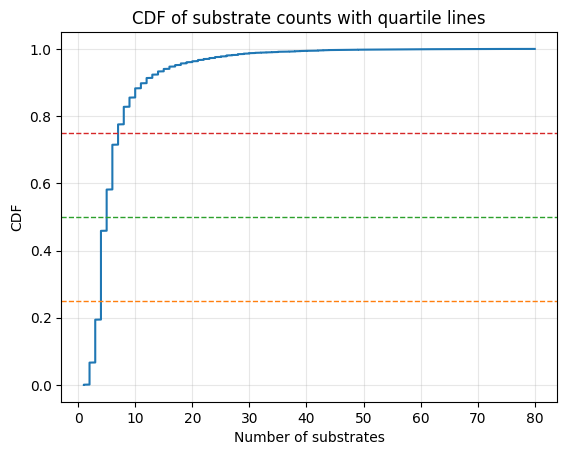

In [ ]:
sub_cts = []
for smi in test_smi | train_smi:
    subs = smi.split('.')
    sub_cts.append(len(subs))

sub_cts = np.array(sub_cts)
print(f"Average number of substrates: {sub_cts.mean():.2f} ± {sub_cts.std():.2f}")
print(f"Max number of substrates: {sub_cts.max()}")

ycdf = np.arange(1, len(sub_cts) + 1) / len(sub_cts)
plt.plot(np.sort(sub_cts), ycdf)
plt.axhline(0.25, color='C1', linestyle='--', linewidth=1)
plt.axhline(0.5, color='C2', linestyle='--', linewidth=1)
plt.axhline(0.75, color='C3', linestyle='--', linewidth=1)
plt.xlabel("Number of substrates")
plt.ylabel("CDF")
plt.title("CDF of substrate counts with quartile lines")
plt.grid(alpha=0.3)
plt.show()


Spot check leaked reactions

In [46]:
i = 0


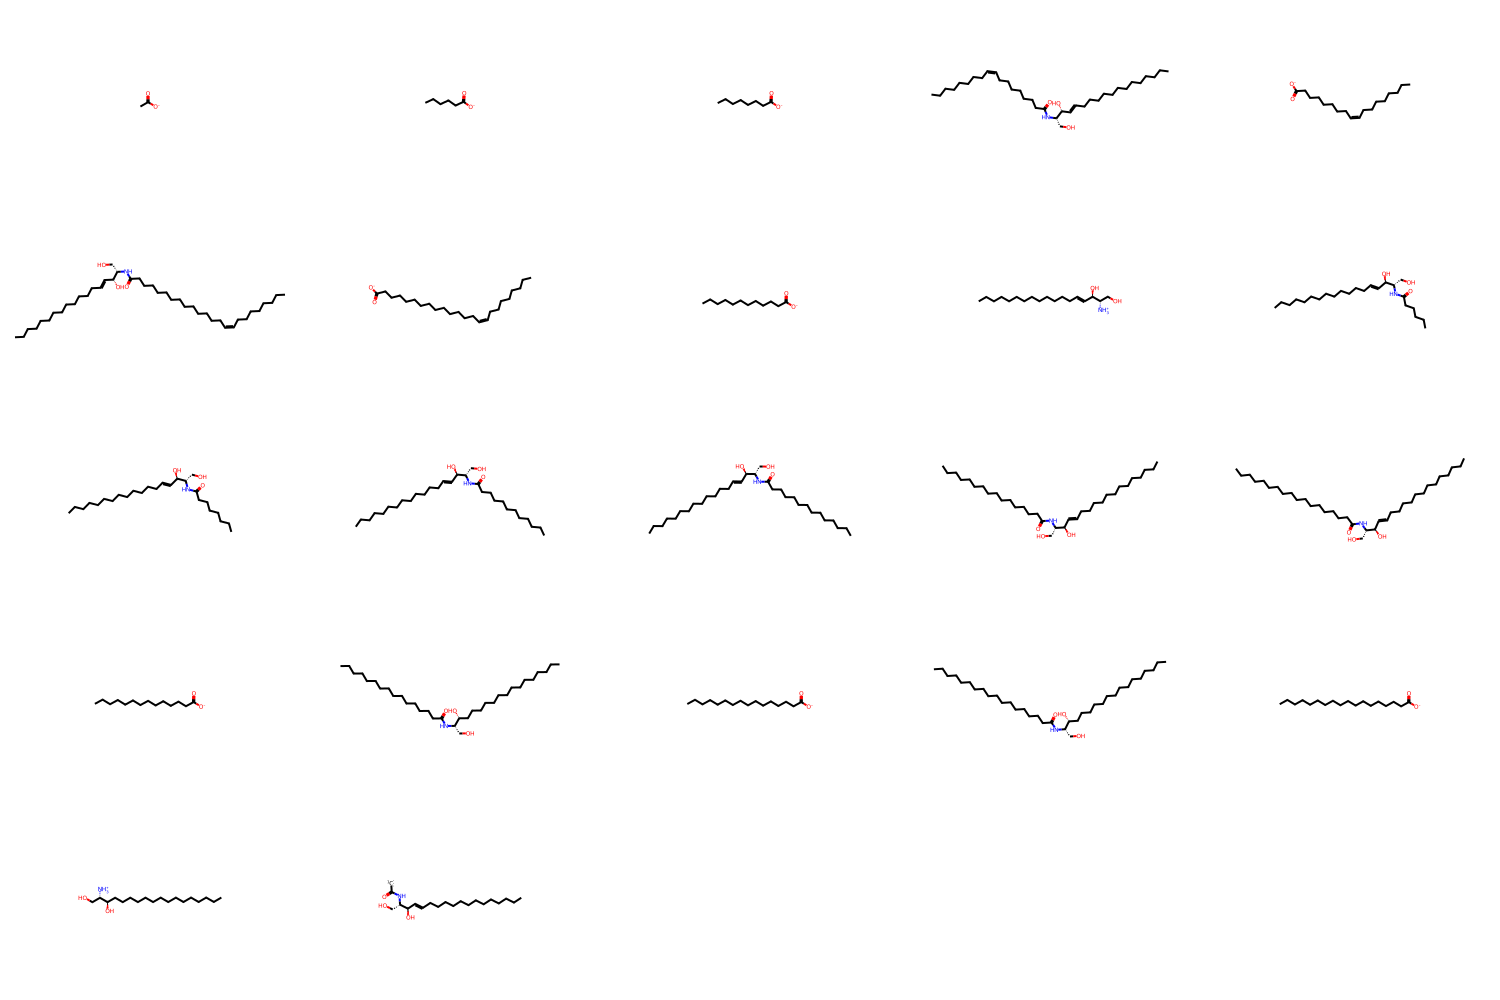

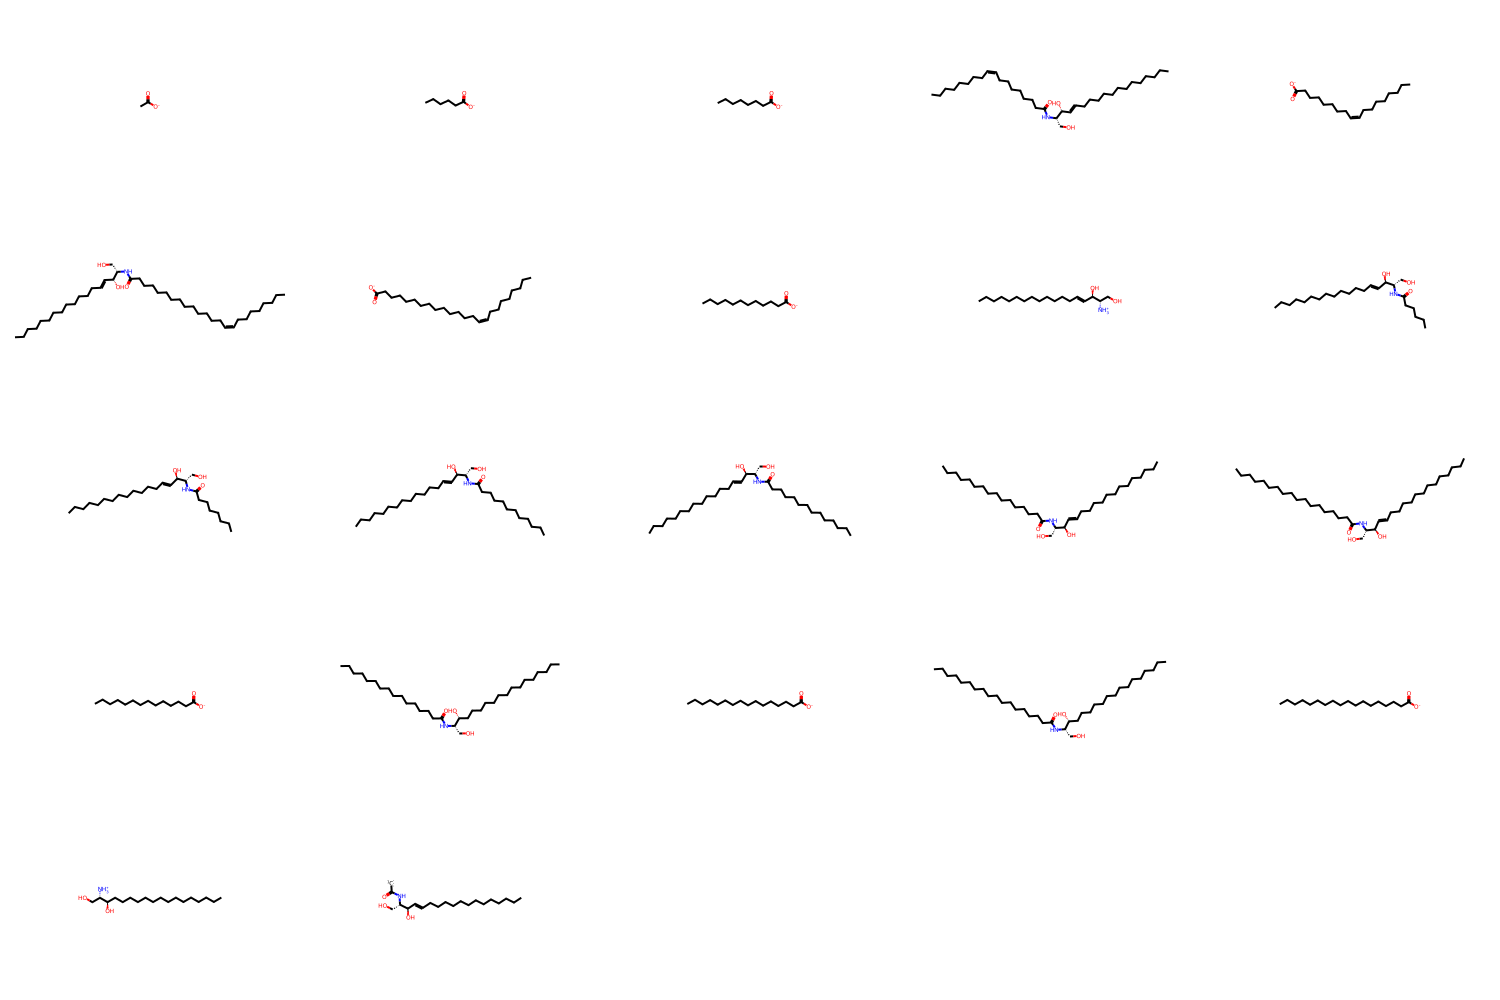

In [62]:

for elt in subset_pairs[i]:
    display(Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in elt.split('.')], molsPerRow=5, subImgSize=(300,200)))

i += 1

0: ['RHEA:13013', 'RHEA:42000', 'RHEA:56740']


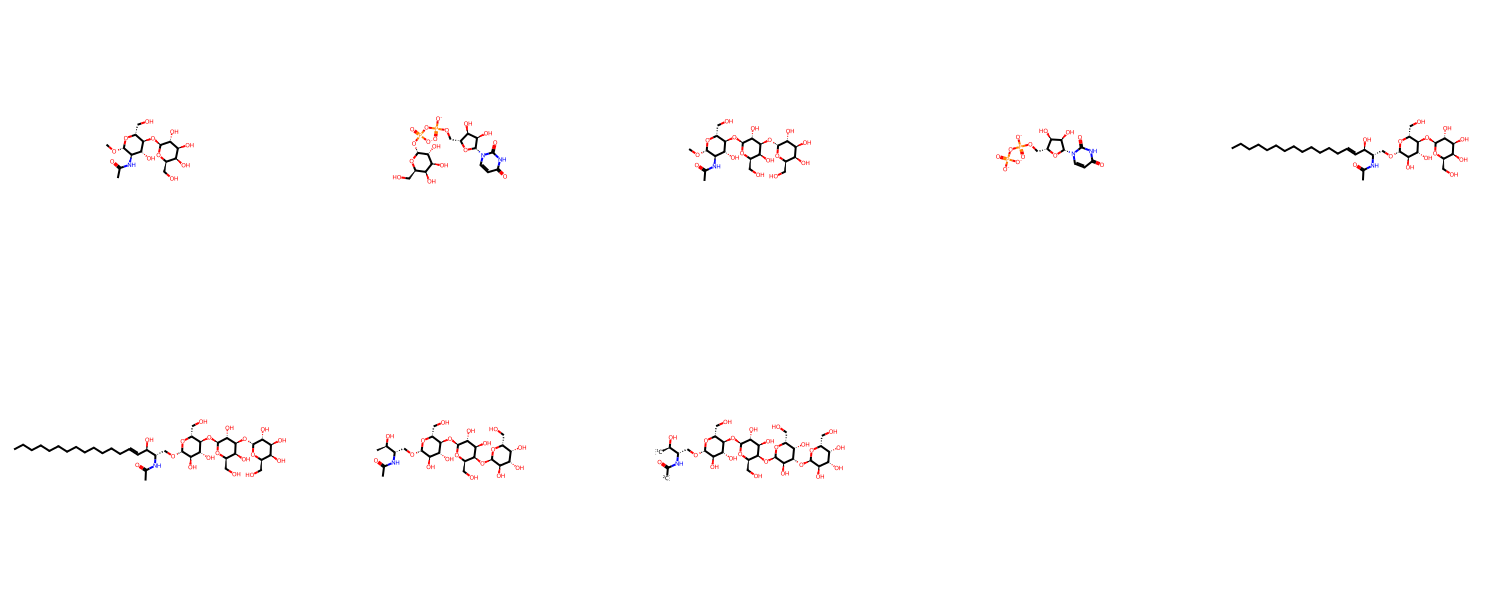

1: ['RHEA:32727', 'RHEA:35327', 'RHEA:36475', 'RHEA:35379', 'RHEA:36503', 'RHEA:36511', 'RHEA:35319', 'RHEA:35315', 'RHEA:36523']


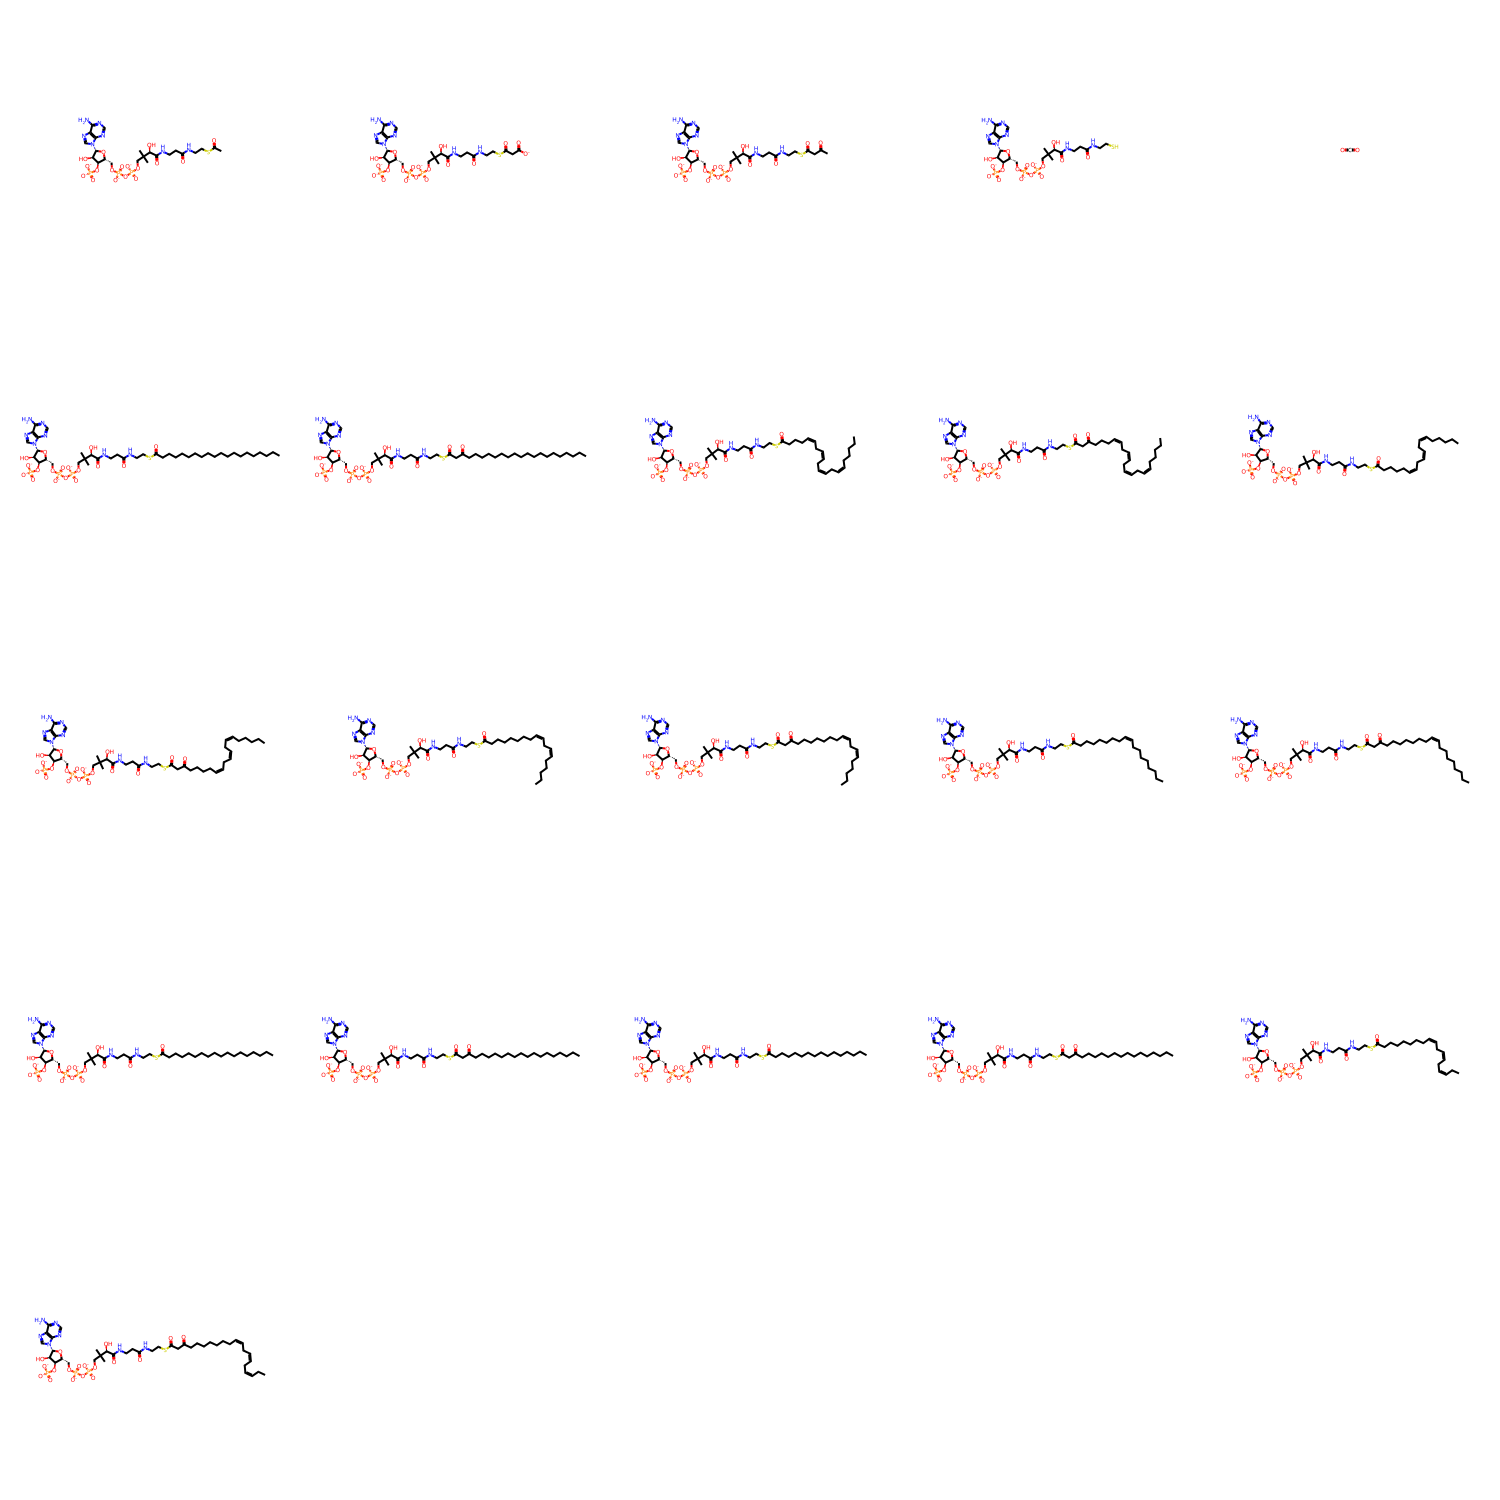

2: ['RHEA:30275', 'RHEA:20309']


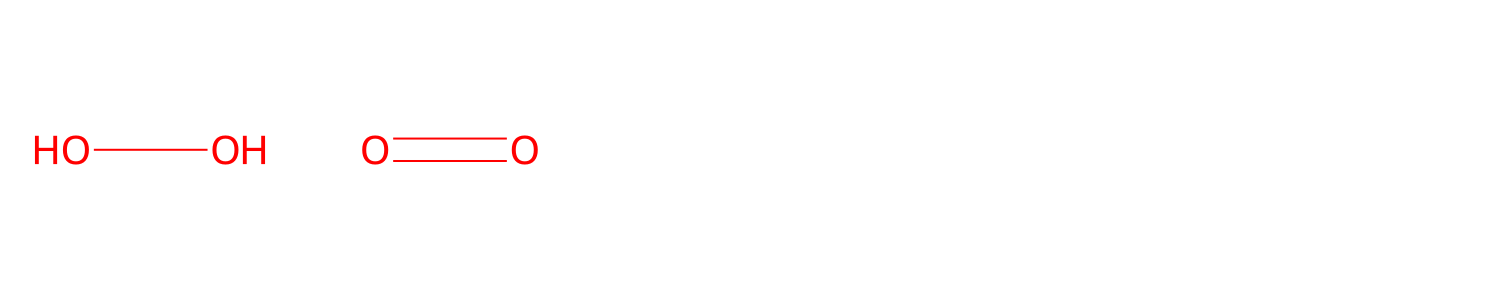

3: ['RHEA:32727', 'RHEA:35327', 'RHEA:36475', 'RHEA:35379', 'RHEA:36503', 'RHEA:36511', 'RHEA:35319', 'RHEA:35315', 'RHEA:36523']


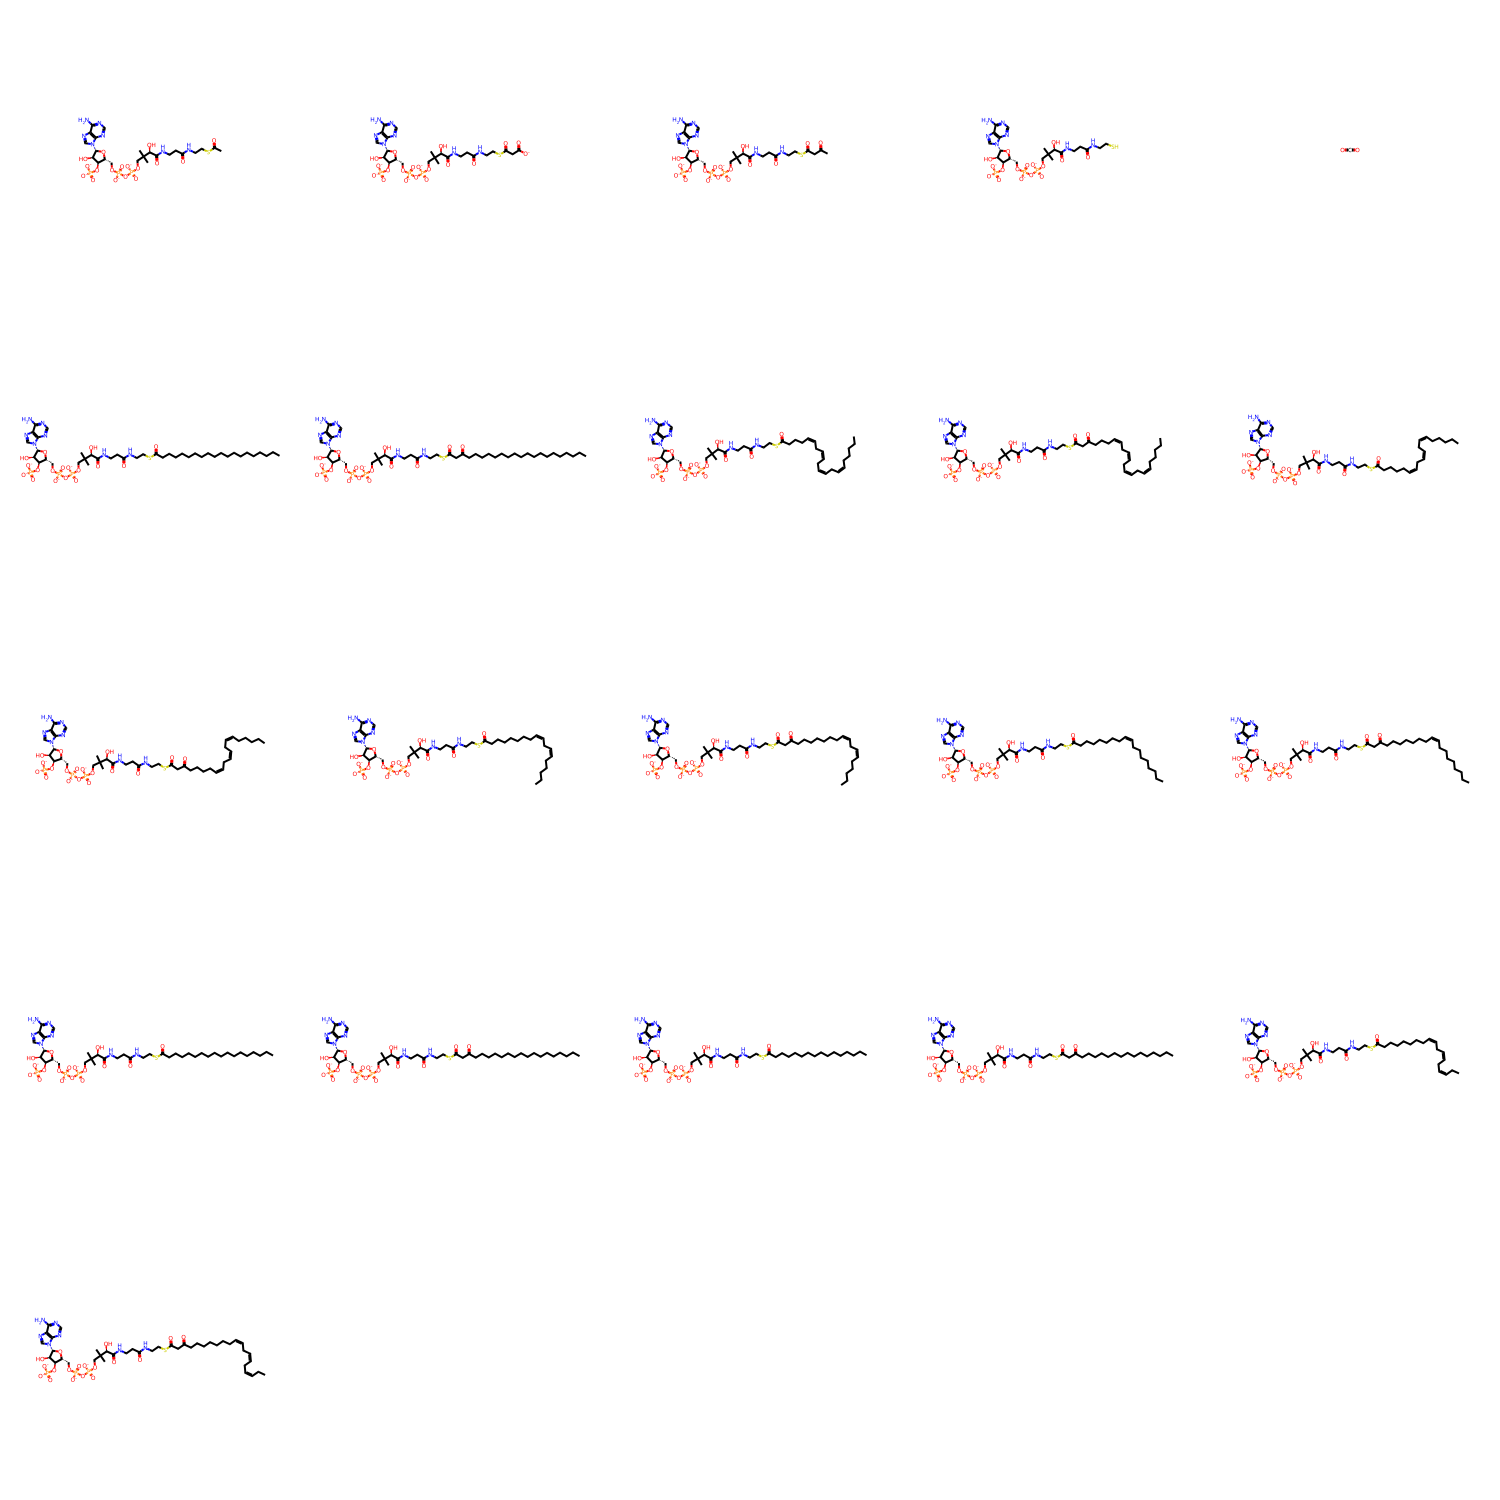

4: ['RHEA:50956', 'RHEA:50960', 'RHEA:60916']


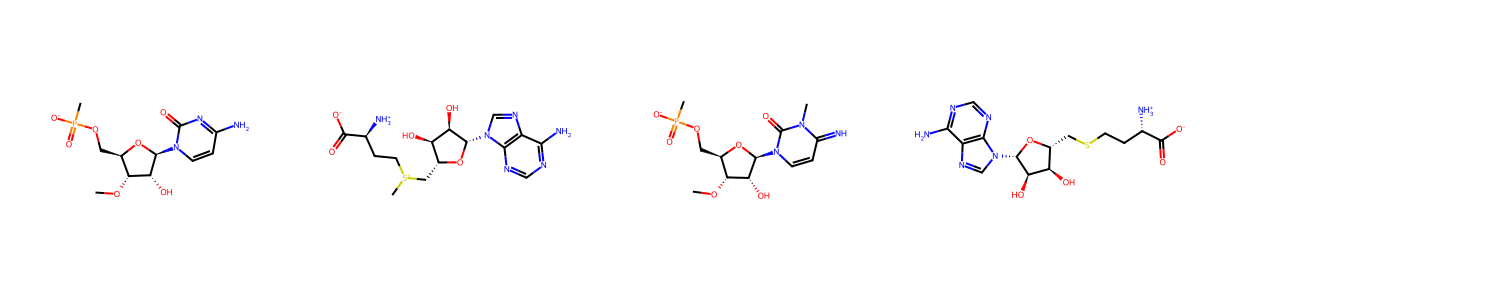

5: ['RHEA:10684', 'RHEA:20629', 'RHEA:47004']


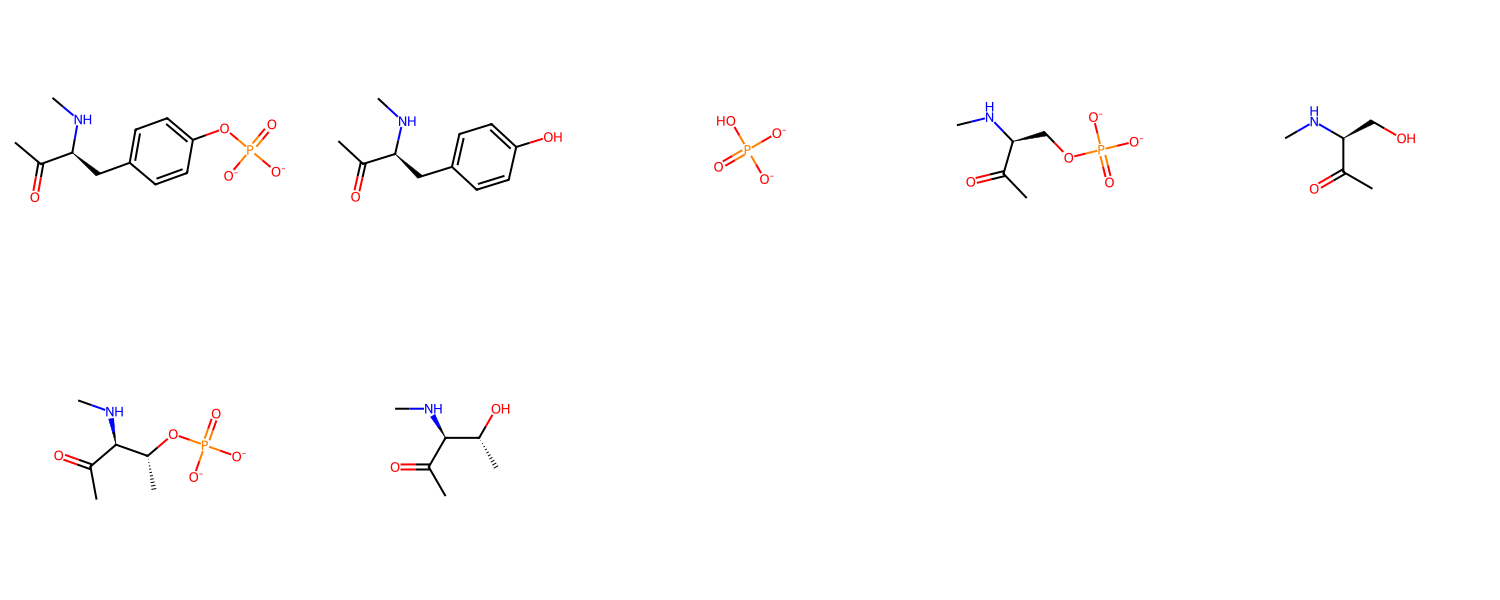

6: ['RHEA:30275', 'RHEA:20309']


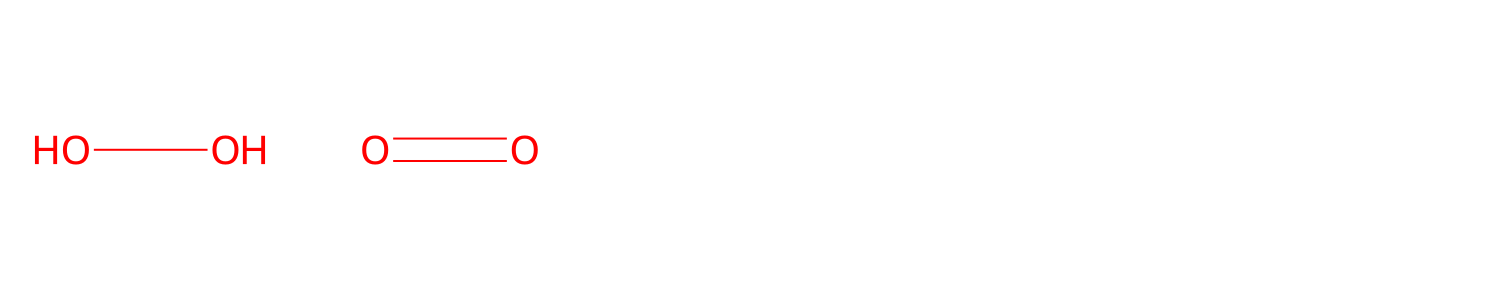

7: ['RHEA:30275', 'RHEA:20309']


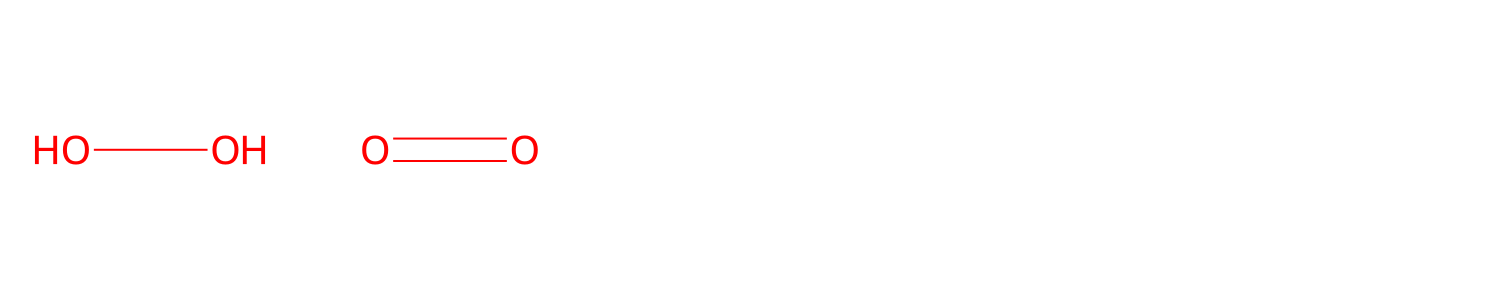

8: ['RHEA:48108']


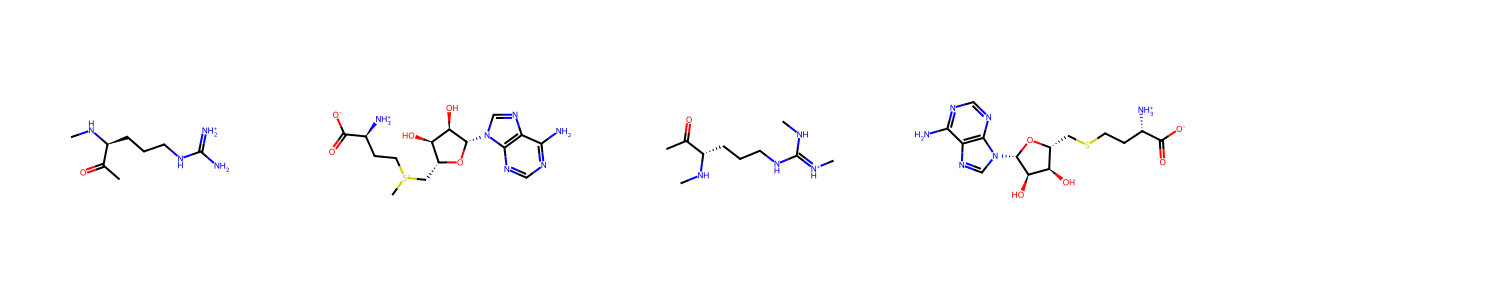

9: ['RHEA:16989']


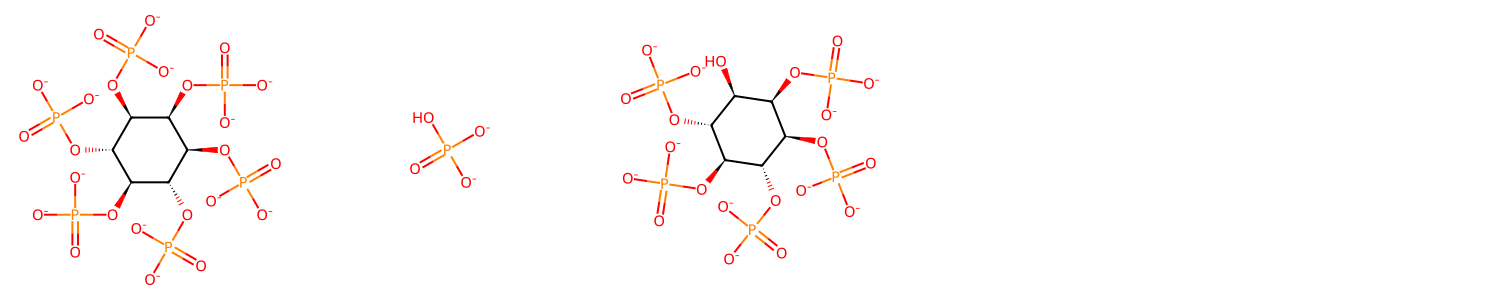

In [24]:
ptms_x_kr = {}
i = 1
ub = 10
for k, (smi, seq) in ptms.items():
    putative_rhea_ids = reactzyme.filter(pl.col("Sequence") == seq)['Rhea ID'].to_list()
    
    putative_rhea_ids = list(chain(*[rhea_id.split(";") for rhea_id in putative_rhea_ids]))
    print(f"{k}: {putative_rhea_ids}")
    display(Draw.MolsToGridImage([Chem.MolFromSmiles(_smi) for _smi in smi.split(".")], molsPerRow=5, subImgSize=(300, 300)))

    i += 1
    if i > ub:
        break


Check reactzyme reaction splitting

In [25]:
def get_rhea_ids(split: dict[int: tuple[str, str]]) -> set[str]:
    rhea_ids = []
    for (smi, seq) in tqdm(split.values(), total=len(split)):
        this_ids = reactzyme.filter(pl.col("Sequence") == seq)['Rhea ID'].to_list()
        this_ids = list(chain(*[rhea_id.split(";") for rhea_id in this_ids]))
        rhea_ids.extend(this_ids)
    return set(rhea_ids)

In [26]:
# test_rhea_ids = get_rhea_ids(ptms)
# train_rhea_ids = get_rhea_ids(ptvms)

# with open(Path(cfg.data) / "reactzyme" / "test_rhea_ids.txt", 'w') as f:
#     for rhea_id in test_rhea_ids:
#         f.write(f"{rhea_id}\n")

# with open(Path(cfg.data) / "reactzyme" / "train_rhea_ids.txt", 'w') as f:
#     for rhea_id in train_rhea_ids:
#         f.write(f"{rhea_id}\n")

In [27]:
with open(Path(cfg.data) / "reactzyme" / "test_rhea_ids.txt", 'r') as f:
    test_rhea_ids = set(line.strip() for line in f)

with open(Path(cfg.data) / "reactzyme" / "train_rhea_ids.txt", 'r') as f:
    train_rhea_ids = set(line.strip() for line in f)

In [28]:
rhea_directions = pl.read_csv(
    Path(cfg.data) / "rhea-directions.tsv",
    separator="\t",
)
rhea_directions.head()

RHEA_ID_MASTER,RHEA_ID_LR,RHEA_ID_RL,RHEA_ID_BI
i64,i64,i64,i64
10000,10001,10002,10003
10004,10005,10006,10007
10008,10009,10010,10011
10012,10013,10014,10015
10016,10017,10018,10019


In [29]:
dataset = 'sprhea'
toc = 'v3_folded_pt_ns'
metric = 'rcmcs'

adj, idx_sample, idx_feature = construct_sparse_adj_mat(
    Path(cfg.data) / dataset / (toc + '.csv')
)

feature_idx = {v: k for k, v in idx_feature.items()}

with open(Path(cfg.data) / dataset / 'v3_folded_pt_ns.json', 'r') as f:
    v3_rxns = json.load(f)

rhea2idx = {}
for idx, v in v3_rxns.items():
    for rhea_id in v['rhea_ids']:
        rhea2idx[rhea_id] = int(idx)

for row in rhea_directions.iter_rows():
    idxs = [rhea2idx[int(rhea_id)] for rhea_id in row if int(rhea_id) in rhea2idx]
    if len(idxs) == 0:
        continue
    else:
        assert len(set(idxs)) == 1
        idx = idxs[0]

        for rhea_id in row:
            if rhea_id not in rhea2idx:
                rhea2idx[int(rhea_id)] = idx


reactzyme_train_idxs = set()
reactzyme_test_idxs = set()
for rhea_id in train_rhea_ids:
    rhea_id = int(rhea_id.removeprefix("RHEA:"))
    if rhea_id in rhea2idx:
        reactzyme_train_idxs.add(rhea2idx[rhea_id])

for rhea_id in test_rhea_ids:
    rhea_id = int(rhea_id.removeprefix("RHEA:"))
    if rhea_id in rhea2idx:
        reactzyme_test_idxs.add(rhea2idx[rhea_id])

reactzyme_train_idxs = np.array(list(reactzyme_train_idxs))
reactzyme_test_idxs = np.array(list(reactzyme_test_idxs))
print(len(reactzyme_train_idxs), len(reactzyme_test_idxs))

Constructing v3_folded_pt_ns sparse adjacency matrix
6120 649


In [30]:


S = np.load(
    Path(cfg.results) / 'similarity_matrices' / f"{dataset}_{toc}_{metric}.npy"
)

S = S.astype(np.float16)

In [31]:
S.shape

(6460, 6460)

In [32]:
print(len(train_rhea_ids), len(test_rhea_ids))
print(len(train_rhea_ids & test_rhea_ids))

10490 979
627


Examine aa seq split

In [53]:
ptss = torch.load(
    Path(cfg.data) / "reactzyme" / "positive_test_seq_smi.pt"
)

ptvss = torch.load(
    Path(cfg.data) / "reactzyme" / "positive_train_val_seq_smi.pt"
)

In [54]:
tr_seqs = set(v[1] for v in ptvss.values())
te_seqs = set(v[1] for v in ptss.values())
print(len(tr_seqs & te_seqs))
tr_seqs = {f"train_{i}": v for i, v in enumerate(tr_seqs)}
te_seqs = {f"test_{i}": v for i, v in enumerate(te_seqs)}
merged_seqs = {**tr_seqs, **te_seqs}
print(len(tr_seqs), len(te_seqs))

3
169596 8734


In [55]:
with open("../artifacts/clustering/reactzyme_merged_seqs.fasta", "w") as f:
    for name, seq in merged_seqs.items():
        f.write(f">{name}\n{seq}\n")

In [58]:
clusters = parse_cd_hit_clusters(
 Path(cfg.clustering) / "reactzyme_90.clstr"
)

In [62]:
test_too_close = set()
mixed_clusters = {}
for k, v in clusters.items():
    if any(elt.startswith("test_") for elt in v) and any(elt.startswith("train_") for elt in v):
        for elt in v:
            if elt.startswith("test_"):
                test_too_close.add(elt)
        mixed_clusters[k] = v

In [64]:
print(f"Number of test sequences within 90% identity of training sequences: {len(test_too_close)} / {len(te_seqs)} = {len(test_too_close)/len(te_seqs):.2%}")

Number of test sequences within 90% identity of training sequences: 4082 / 8734 = 46.74%


Enzymecage

In [9]:
ec_train = pl.read_csv(
    Path(cfg.data) / "enzymecage" / "training" / "train.csv",
)

ec_valid = pl.read_csv(
    Path(cfg.data) / "enzymecage" / "training" / "valid.csv",
)

e405 = pl.read_csv(
    Path(cfg.data) / "enzymecage" / "internal-test-set" / "Enzyme-405" / "Enzyme-405.csv",
)

o335 = pl.read_csv(
    Path(cfg.data) / "enzymecage" / "internal-test-set" / "Orphan-335" / "Orphan-335.csv",
)

In [19]:
ec_up = set(ec_train['UniprotID'].to_list()) | set(ec_valid['UniprotID'].to_list()) | set(e405['UniprotID'].to_list()) | set(o335['UniprotID'].to_list())
ec_up = set(e405['UniprotID'].to_list())

In [20]:
ec_xref = kes.filter(
    pl.col("id").is_in(ec_up)
)
ec_n_subunits = ec_xref.filter(pl.col("subunit") == True).height
ec_n_protein_level = ec_xref.filter(pl.col("existence") == "Evidence at protein level").height
ec_n_transcript_level = ec_xref.filter(pl.col("existence") == "Evidence at transcript level").height
ec_n_inferred = ec_xref.filter(pl.col("existence") == "Inferred from homology").height
ec_n_predicted = ec_xref.filter(pl.col("existence") == "Predicted").height
ec_n_uncertain = ec_xref.filter(pl.col("existence") == "Uncertain").height
ec_tot = len(ec_up) #ec_xref.height

print(f"Protein level evidence: {ec_n_protein_level} ({ec_n_protein_level/ec_tot:.2%})")
print(f"Transcript level evidence: {ec_n_transcript_level} ({ec_n_transcript_level/ec_tot:.2%})")
print(f"Inferred from homology: {ec_n_inferred} ({ec_n_inferred/ec_tot:.2%})")
print(f"Predicted: {ec_n_predicted} ({ec_n_predicted/ec_tot:.2%})")
print(f"Uncertain: {ec_n_uncertain} ({ec_n_uncertain/ec_tot:.2%})")
print(f"Subunits: {ec_n_subunits} ({ec_n_subunits/ec_tot:.2%})")
print(f"Total: {ec_tot}")

Protein level evidence: 3879 (45.03%)
Transcript level evidence: 942 (10.93%)
Inferred from homology: 3782 (43.90%)
Predicted: 8 (0.09%)
Uncertain: 4 (0.05%)
Subunits: 964 (11.19%)
Total: 8615


In [18]:
e405

RHEA_ID,DIRECTION,MASTER_ID,UniprotID,SMILES,EC number,CANO_RXN_SMILES,sequence,reverse_template,n_seq,rxnmapper_template,localmapper_template,Label,similar_rxn,rxn_similarity,n_enzymes
i64,str,i64,str,str,str,str,str,str,i64,str,str,i64,str,f64,f64
81171,"""UN""",81171,"""A6ZZV7""","""CCCCCC[C@@H](O)CCCCCC/C=C/[C@H…",null,"""CC(=O)SCCNC(=O)CCNC(=O)[C@H](O…","""MSTIKPSPSNNNLKVRSRPRRKSSIGKIDL…","""[C:1]-[SH;D1;+0:2].[C:6]=[C:7]…",515,"""[C:1]-[SH;D1;+0:2].[C:6]=[C:7]…","""[C:1]-[SH;D1;+0:2].[C:6]=[C:7]…",0,"""*C(=O)SCCNC(=O)CCNC(=O)[C@H](O…",0.577803,2.0
78495,"""UN""",78495,"""Q7VLN6""","""NC1=NC(=O)N([C@@H]2O[C@H](COP(…",null,"""CC(=O)SCCNC(=O)CCNC(=O)[C@H](O…","""MRQLVILSTMPPIQGGVLLNSQNFSKAKQF…","""[C:1]-[N;H0;D3;+0:2](-[O;D1;H1…",286,"""[C:1]-[N;H0;D3;+0:2](-[O;D1;H1…","""[C:1]-[N;H0;D3;+0:2](-[O;D1;H1…",0,"""*O[C@H]1[C@@H](O)[C@H](n2ccc(N…",0.644309,2.0
80951,"""UN""",80951,"""Q0T128""","""[1*][C@@H](O)CC(=O)NCC(=O)[O-]…",null,"""*N[C@@H](COP(=O)(O)OCC(C)(C)[C…","""MLFSFFRNLCRVLYRVRVTGDTQALKGERV…","""[C:1]-[O;H0;D2;+0:2]-[C;H0;D3;…",279,"""[C:1]-[O;H0;D2;+0:2]-[C;H0;D3;…","""[C:1]-[O;H0;D2;+0:2]-[C;H0;D3;…",0,"""*N[C@@H](COP(=O)(O)OCC(C)(C)[C…",0.679261,4.0
79655,"""UN""",79655,"""P97519""","""CC(=O)CC(=O)CC(=O)[O-].CC(=O)S…","""2.3.1.319""","""CC(=O)CC(=O)CC(=O)O.CC(=O)SCCN…","""MATVRKAFPQRLVGLASLRAASTSSMGTLP…","""[#16:1]-[C;H0;D3;+0:2](=[O;D1;…",310,"""[#16:1]-[C;H0;D3;+0:2](=[O;D1;…","""[#16:1]-[C;H0;D3;+0:2](=[O;D1;…",0,"""CC(=O)SCCNC(=O)CCNC(=O)[C@H](O…",0.81407,1.0
76107,"""UN""",76107,"""A0A0N9HQ36""","""COC(=O)C(/C=C/C1=C(C)CCCC1(C)C…",null,"""COC(=O)C(/C=C/C1=C(C)CCCC1(C)C…","""MGSTAPLRLPVIDLSMKNLKPGTTSWNSVR…","""[C:5]-[C;H0;D3;+0:6](=[O;D1;H0…",364,"""[C:5]-[C;H0;D3;+0:6](=[O;D1;H0…","""[C:5]-[C;H0;D3;+0:6](=[O;H0;D1…",0,"""C[C@@H]1Cc2c3c(cc(O)c2C(=O)O1)…",0.716848,2.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
81407,"""UN""",81407,"""Q6G754""","""NC1=NC=NC2=C1N=CN2[C@H]1C[C@H]…","""5.3.99.13""","""C[S+](CC[C@H](N)C(=O)O)C[C@H]1…","""MVEQIKDKLGRPIRDLRLSVTDRCNFRCDY…","""[#8:1]-[C:2]-[CH3;D1;+0:3].[C:…",744,"""[#8:1]-[C:2]-[CH3;D1;+0:3].[C:…","""[#8:1]-[CH2;D2;+0:2]-[C@H;D3;+…",0,"""*O[C@H]1[C@@H](O)[C@H](n2cnc3c…",0.673229,2.0
80203,"""UN""",80203,"""G8XQX1""","""O=C([O-])C1=CC=C(NO)C=C1.[H]O[…",null,"""O.O=C(O)c1ccc(NO)cc1>>N.O=C(O)…","""MNVFFMFSLLFLATLGSCADDKNPLEECFR…","""[NH3;D0;+0:3].[OH;D1;+0:1]-[c;…",176,"""[NH3;D0;+0:3].[OH;D1;+0:1]-[c;…","""[NH3;D0;+0:3].[OH;D1;+0:2]-[c;…",0,"""NC[C@H](O)c1ccc(O)c(O)c1.O.O=O…",0.647155,2.0
81367,"""UN""",81367,"""P20456""","""[H][C@]1(COP(=O)([O-])[O-])O[C…","""3.1.3.112""","""Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO…","""MADPWQECMDYAVTLAGQAGEVVREALKNE…","""[C:1]-[OH;D1;+0:2].[O;D1;H0:4]…",194,"""[C:1]-[OH;D1;+0:2].[O;D1;H0:4]…","""[C:1]-[OH;D1;+0:2].[O;D1;H0:4]…",0,"""Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO…",0.77155,2.0


In [23]:
ec_xref.filter(pl.col("subunit") == True)['id'].to_list()

['E7FHH1',
 'E7FHP1',
 'E7FI45',
 'G1UBD1',
 'I3R9M8',
 'I3R9M9',
 'I5AX50',
 'O31041',
 'O31042',
 'O80642',
 'O85673',
 'O96007',
 'P00326',
 'P07327',
 'P08263',
 'P0DPQ7',
 'P11349',
 'P11350',
 'P16127',
 'P18898',
 'P19468',
 'P20133',
 'P21156',
 'P25079',
 'P26164',
 'P28469',
 'P29702',
 'P29703',
 'P35575',
 'P35576',
 'P37349',
 'P37450',
 'P38138',
 'P40875',
 'P43428',
 'P48506',
 'P49354',
 'P53609',
 'P53610',
 'P53612',
 'P61599',
 'P70665',
 'P70752',
 'P76014',
 'P76015',
 'P76077',
 'P76458',
 'P76459',
 'P78537',
 'P79403',
 'P81291',
 'P82450',
 'P94405',
 'P97494',
 'P9WJA1',
 'Q00618',
 'Q03216',
 'Q03503',
 'Q06504',
 'Q08602',
 'Q08603',
 'Q08689',
 'Q0IIJ0',
 'Q0QLF1',
 'Q0QLF2',
 'Q0QLF3',
 'Q14697',
 'Q147X3',
 'Q1QYU6',
 'Q1QYU7',
 'Q38HX4',
 'Q47208',
 'Q4PBE6',
 'Q4R4N7',
 'Q4X0W8',
 'Q50LE9',
 'Q50LF0',
 'Q50LF1',
 'Q50LF2',
 'Q58409',
 'Q58667',
 'Q58673',
 'Q59127',
 'Q59128',
 'Q5RF28',
 'Q5W9R9',
 'Q5XF33',
 'Q5XGA9',
 'Q61239',
 'Q6ATS0',
 'Q6DBY2',